In [1]:
import pandas as pd
deliveries_df = pd.read_csv("/Users/mwp52/Downloads/CSKvMI_IPL2024.csv")

print(deliveries_df.head())

   Unnamed: 0  match_id  season  match_no          date  \
0        6837    202429    2024        29  Apr 14, 2024   
1        6838    202429    2024        29  Apr 14, 2024   
2        6839    202429    2024        29  Apr 14, 2024   
3        6840    202429    2024        29  Apr 14, 2024   
4        6841    202429    2024        29  Apr 14, 2024   

                      venue batting_team bowling_team  innings  over  ...  \
0  Wankhede Stadium, Mumbai          CSK           MI        1   0.1  ...   
1  Wankhede Stadium, Mumbai          CSK           MI        1   0.2  ...   
2  Wankhede Stadium, Mumbai          CSK           MI        1   0.3  ...   
3  Wankhede Stadium, Mumbai          CSK           MI        1   0.4  ...   
4  Wankhede Stadium, Mumbai          CSK           MI        1   0.5  ...   

  runs_of_bat extras wide  legbyes  byes  noballs  wicket_type  \
0           0      0    0        0     0        0          NaN   
1           1      0    0        0     0        0 

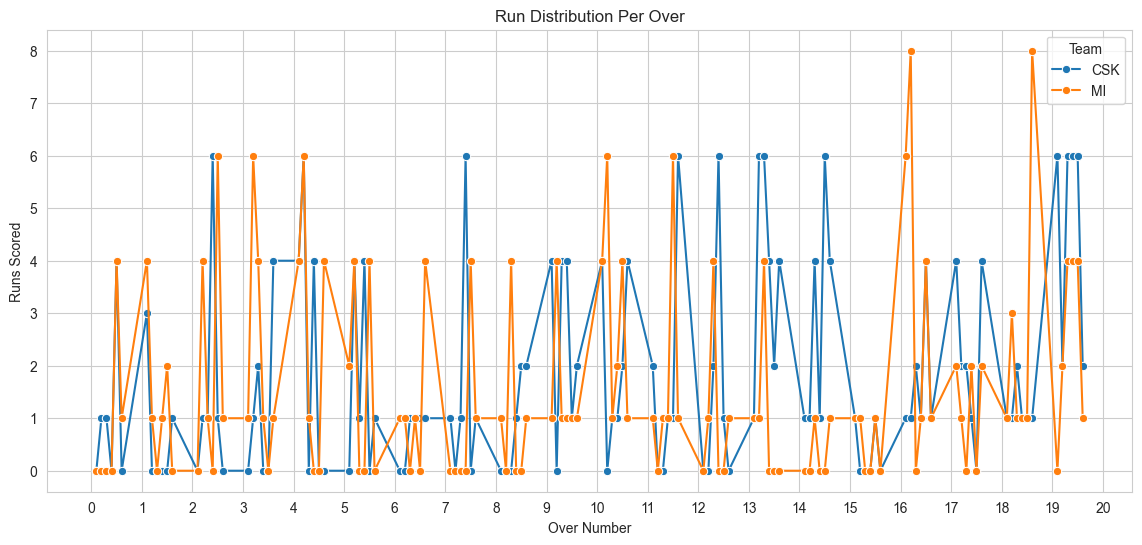

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# data preparation for run distribution per over
run_distribution = deliveries_df.groupby(['batting_team', 'over']).agg({'runs_total': 'sum'}).reset_index()

# plotting run distribution per over for both teams
plt.figure(figsize=(14, 6))
sns.lineplot(data=run_distribution, x='over', y='runs_total', hue='batting_team', marker='o')
plt.title('Run Distribution Per Over')
plt.xlabel('Over Number')
plt.ylabel('Runs Scored')
plt.xticks(range(0, 21))  # over numbers from 0 to 20
plt.legend(title='Team')
plt.show()

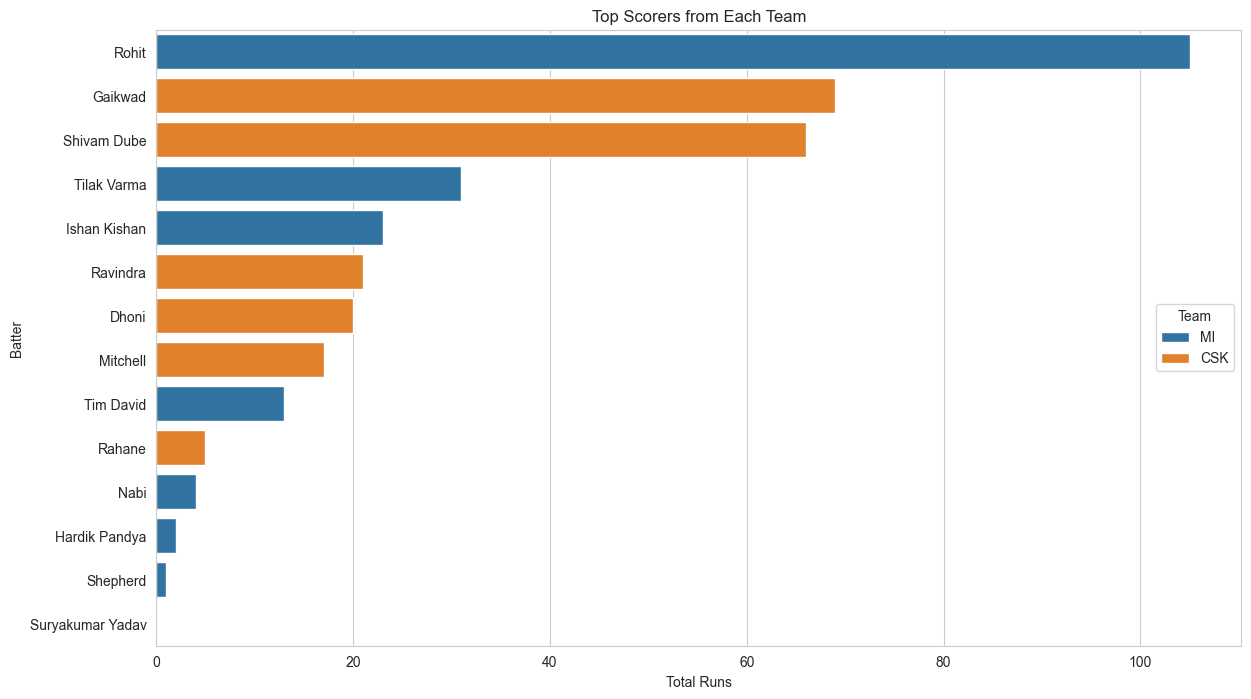

In [3]:
# calculating top scorers for each team
top_scorers = deliveries_df.groupby(['batting_team', 'striker']).agg({'runs_of_bat': 'sum'}).reset_index().sort_values(by='runs_of_bat', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_scorers, x='runs_of_bat', y='striker', hue='batting_team', dodge=False)
plt.title('Top Scorers from Each Team')
plt.xlabel('Total Runs')
plt.ylabel('Batter')
plt.legend(title='Team', loc='center right')
plt.show()

In [4]:
# preparing data for bowling analysis
deliveries_df['wickets_taken'] = deliveries_df['wicket_type'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['batting_team', 'bowler']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'nunique'}).reset_index()

In [5]:
# calculating economy rate (total runs conceded / number of overs bowled)
bowling_stats['economy_rate'] = bowling_stats['runs_total'] / bowling_stats['over']

In [6]:
# sorting the data for better visualization
bowling_stats_sorted = bowling_stats.sort_values(by='wickets_taken', ascending=False)

In [7]:
# prepare the DataFrame for plotting
bowling_stats_sorted['wickets_taken'] = deliveries_df['wicket_type'].notna().astype(int)
bowling_stats = deliveries_df.groupby(['batting_team', 'bowler']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'nunique'}).reset_index()
bowling_stats['economy_rate'] = bowling_stats['runs_total'] / bowling_stats['over']
bowling_stats_sorted = bowling_stats.sort_values(by='wickets_taken', ascending=False)

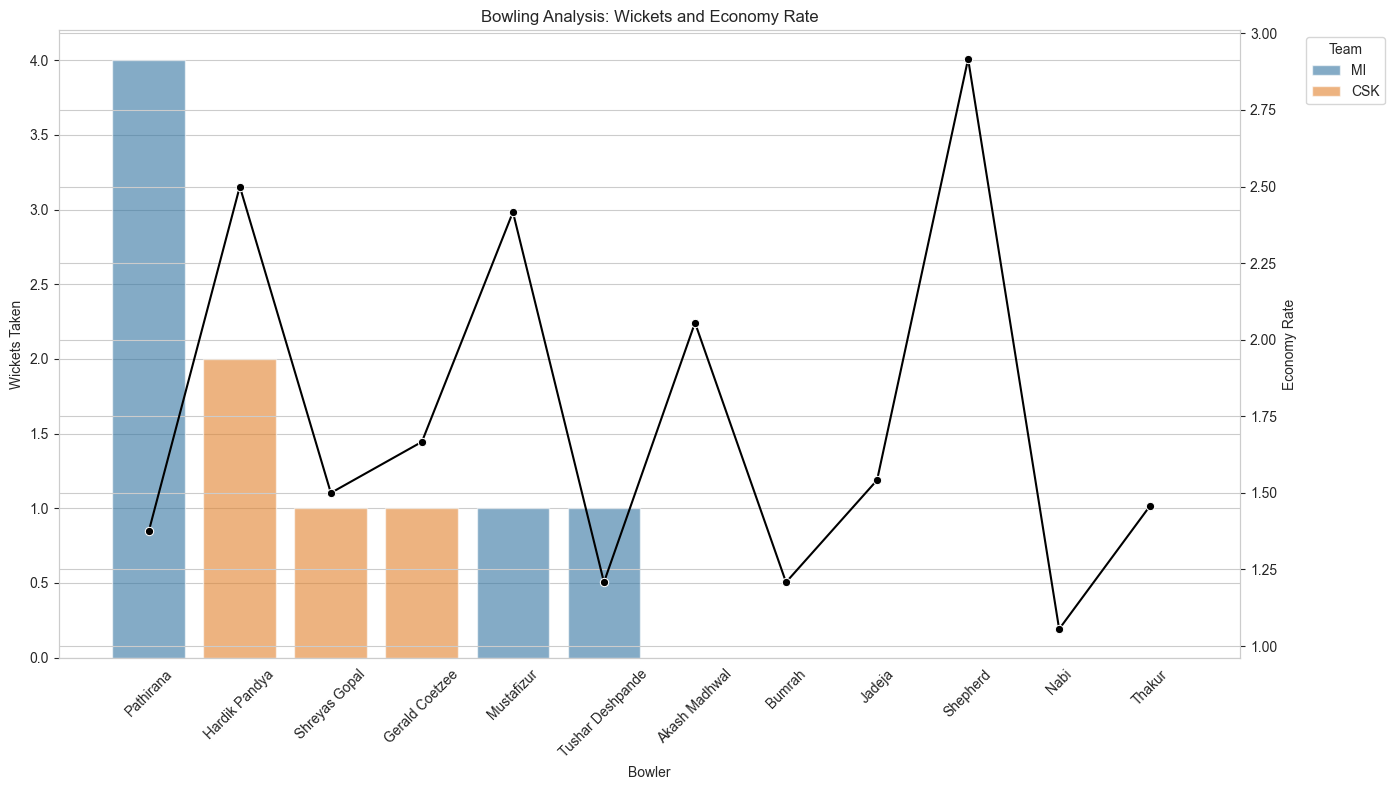

In [8]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for wickets
sns.barplot(data=bowling_stats_sorted, x='bowler', y='wickets_taken', hue='batting_team', ax=ax1, alpha=0.6)
ax1.set_ylabel('Wickets Taken')
ax1.set_xlabel('Bowler')
ax1.set_title('Bowling Analysis: Wickets and Economy Rate')
ax1.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')

for item in ax1.get_xticklabels():
    item.set_rotation(45)

ax2 = ax1.twinx()
sns.lineplot(data=bowling_stats_sorted, x='bowler', y='economy_rate', marker='o', sort=False, ax=ax2, color='black')
ax2.set_ylabel('Economy Rate')

plt.tight_layout()
plt.show()

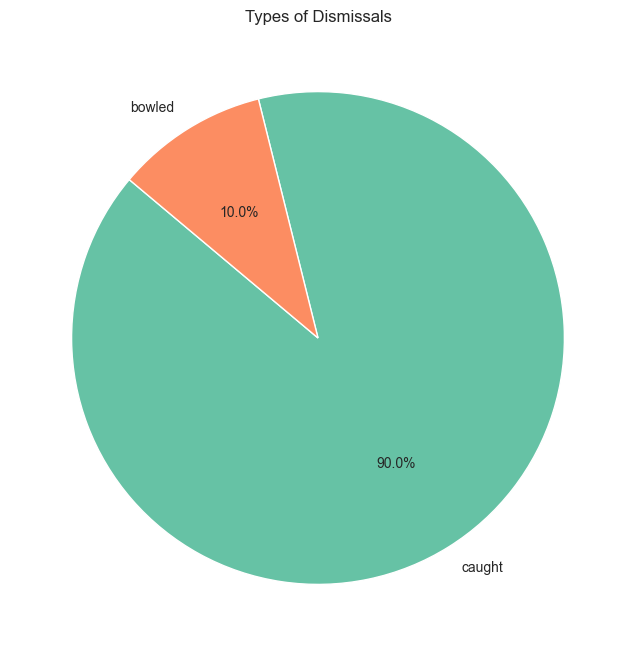

In [9]:
# counting dismissal types
dismissal_types = deliveries_df['wicket_type'].dropna().value_counts()

plt.figure(figsize=(8, 8))
plt.pie(dismissal_types, labels=dismissal_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Types of Dismissals')
plt.show()

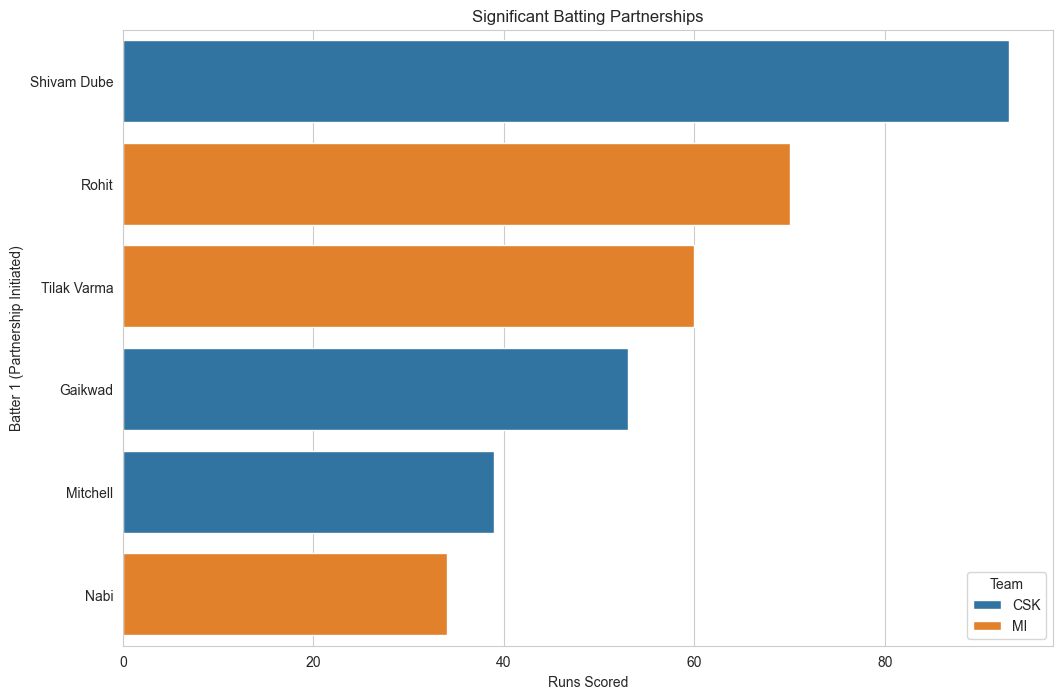

In [10]:
# function to calculate partnerships
def calculate_partnerships(df):
    partnerships = []
    current_partnership = {}
    for i, row in df.iterrows():
        if i == 0 or (row['striker'] not in current_partnership.values()):
            if current_partnership:
                partnerships.append(current_partnership)
            current_partnership = {
                'batting_team': row['batting_team'],
                'striker': row['striker'],
                'non_striker': row['non_striker'],
                'runs': 0,
                'balls': 0
            }
        current_partnership['runs'] += row['runs_total']
        current_partnership['balls'] += 1
        if 'player_dismissed' in row and pd.notna(row['player_dismissed']):
            if row['player_dismissed'] == current_partnership['striker'] or row['player_dismissed'] == current_partnership['non_striker']:
                partnerships.append(current_partnership)
                current_partnership = {}
    # append the last partnership if not ended by a wicket
    if current_partnership:
        partnerships.append(current_partnership)
    return partnerships

# calculate partnerships
partnerships_data = calculate_partnerships(deliveries_df)
partnerships_df = pd.DataFrame(partnerships_data)

# filter out significant partnerships (e.g., partnerships with more than 20 runs)
significant_partnerships = partnerships_df[partnerships_df['runs'] > 20]

# sort by highest runs
significant_partnerships = significant_partnerships.sort_values(by='runs', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=significant_partnerships, x='runs', y='striker', hue='batting_team', dodge=False)
plt.title('Significant Batting Partnerships')
plt.xlabel('Runs Scored')
plt.ylabel('Batter 1 (Partnership Initiated)')
plt.legend(title='Team')
plt.show()

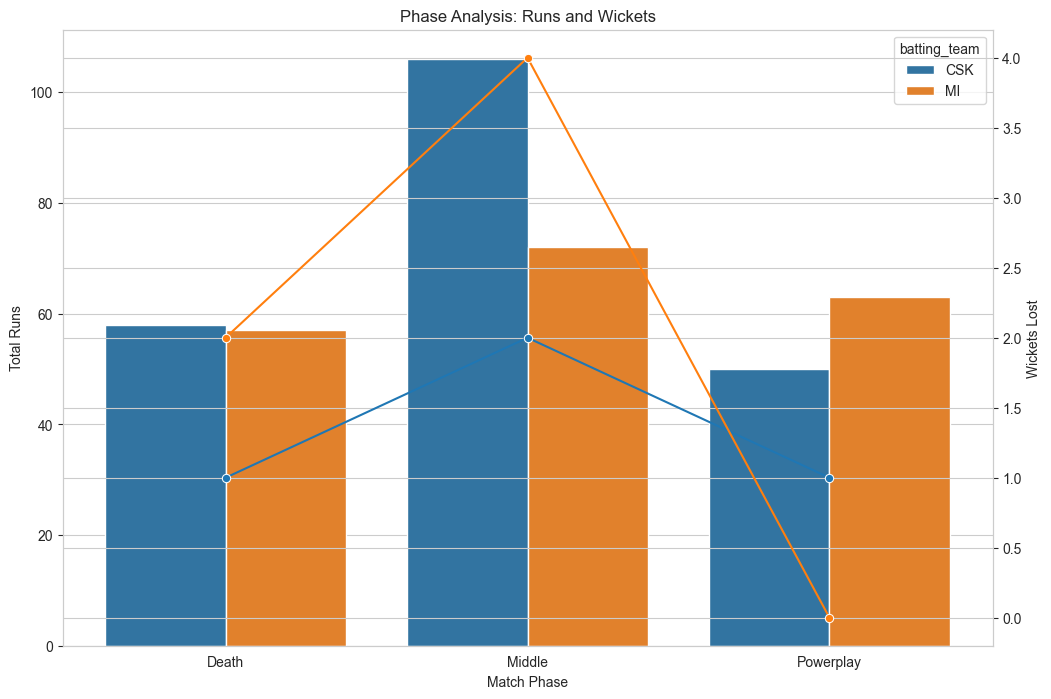

In [11]:
# function to classify the phase of the game based on the over number
def classify_phase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'

# adding phase information to the dataframe
deliveries_df['phase'] = deliveries_df['over'].apply(classify_phase)
deliveries_df['wickets_taken'] = deliveries_df['wicket_type'].notna().astype(int)

# grouping data by phase and team to calculate runs and wickets
phase_analysis = deliveries_df.groupby(['batting_team', 'phase']).agg({'runs_total': 'sum', 'wickets_taken': 'sum', 'over': 'count'}).rename(columns={'over': 'balls'}).reset_index()

# calculating the run rate
phase_analysis['run_rate'] = (phase_analysis['runs_total'] / phase_analysis['balls']) * 6

# plotting the phase analysis
fig, ax1 = plt.subplots(figsize=(12, 8))

# bar plot for runs scored in each phase
sns.barplot(data=phase_analysis, x='phase', y='runs_total', hue='batting_team', ax=ax1)
ax1.set_title('Phase Analysis: Runs and Wickets')
ax1.set_ylabel('Total Runs')
ax1.set_xlabel('Match Phase')

# line plot for wickets lost
ax2 = ax1.twinx()
sns.lineplot(data=phase_analysis, x='phase', y='wickets_taken', hue='batting_team', marker='o', ax=ax2, legend=False)
ax2.set_ylabel('Wickets Lost')

plt.show()

In [12]:
# calculate runs and balls faced for each batter
batter_stats = deliveries_df.groupby('striker').agg({'runs_of_bat': 'sum', 'over': 'count'}).rename(columns={'over': 'balls_faced'}).reset_index()

# calculate strike rate for each batter (runs per 100 balls)
batter_stats['strike_rate'] = (batter_stats['runs_of_bat'] / batter_stats['balls_faced']) * 100

# sorting batters by their strike rate
batter_stats_sorted = batter_stats.sort_values(by='strike_rate', ascending=False)

# displaying calculated strike rates along with runs scored and balls faced
batter_stats_sorted.head(10)

,striker,runs_of_bat,balls_faced,strike_rate
0,Dhoni,20,4,500.000000
13,Tim David,13,6,216.666667
10,Shivam Dube,66,38,173.684211
1,Gaikwad,69,41,168.292683
8,Rohit,105,66,159.090909
12,Tilak Varma,31,20,155.000000
3,Ishan Kishan,23,15,153.333333
7,Ravindra,21,18,116.666667
4,Mitchell,17,16,106.250000
6,Rahane,5,8,62.500000


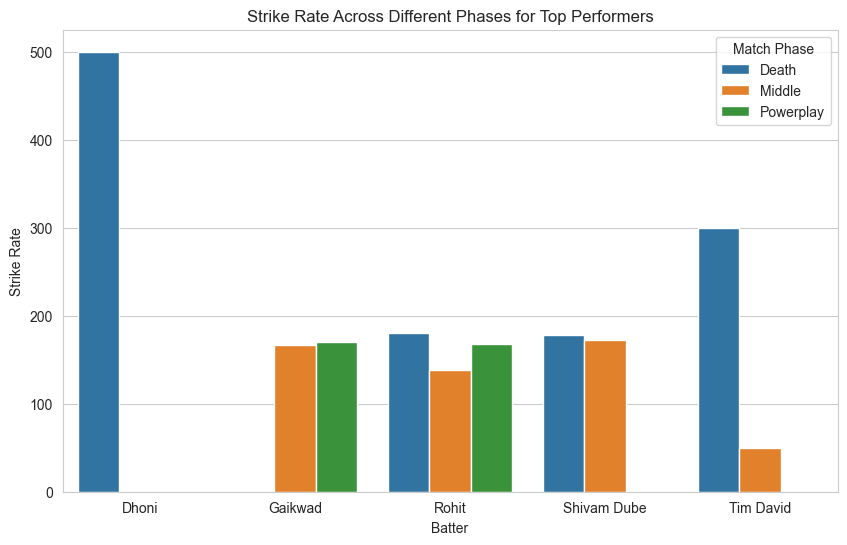

In [15]:
def classify_phase(over):
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'
deliveries_df['phase'] = deliveries_df['over'].apply(classify_phase)

# merging phase information with batter stats
batter_phase_stats = deliveries_df.groupby(['striker', 'phase']).agg({'runs_of_bat': 'sum', 'over': 'count'}).rename(columns={'over': 'balls_faced'}).reset_index()

# calculate strike rate for each batter-phase combination
batter_phase_stats['strike_rate'] = (batter_phase_stats['runs_of_bat'] / batter_phase_stats['balls_faced']) * 100

# filtering for top performers based on overall strike rate
top_performers = batter_stats_sorted.head(5)['striker']
batter_phase_stats_top = batter_phase_stats[batter_phase_stats['striker'].isin(top_performers)]

# plotting strike rate across different phases for top performers
plt.figure(figsize=(10, 6))
sns.barplot(data=batter_phase_stats_top, x='striker', y='strike_rate', hue='phase')
plt.title('Strike Rate Across Different Phases for Top Performers')
plt.xlabel('Batter')
plt.ylabel('Strike Rate')
plt.legend(title='Match Phase')
plt.show()

/var/folders/3d/6l22bk8d781g31mx3zlpxck00000gn/T/ipykernel_2770/4227913592.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_deliveries['over_ball'] = mi_deliveries['over'] + (mi_deliveries.groupby('over').cumcount() + 1) / 6
/var/folders/3d/6l22bk8d781g31mx3zlpxck00000gn/T/ipykernel_2770/4227913592.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csk_deliveries['over_ball'] = csk_deliveries['over'] + (csk_deliveries.groupby('over').cumcount() + 1) / 6


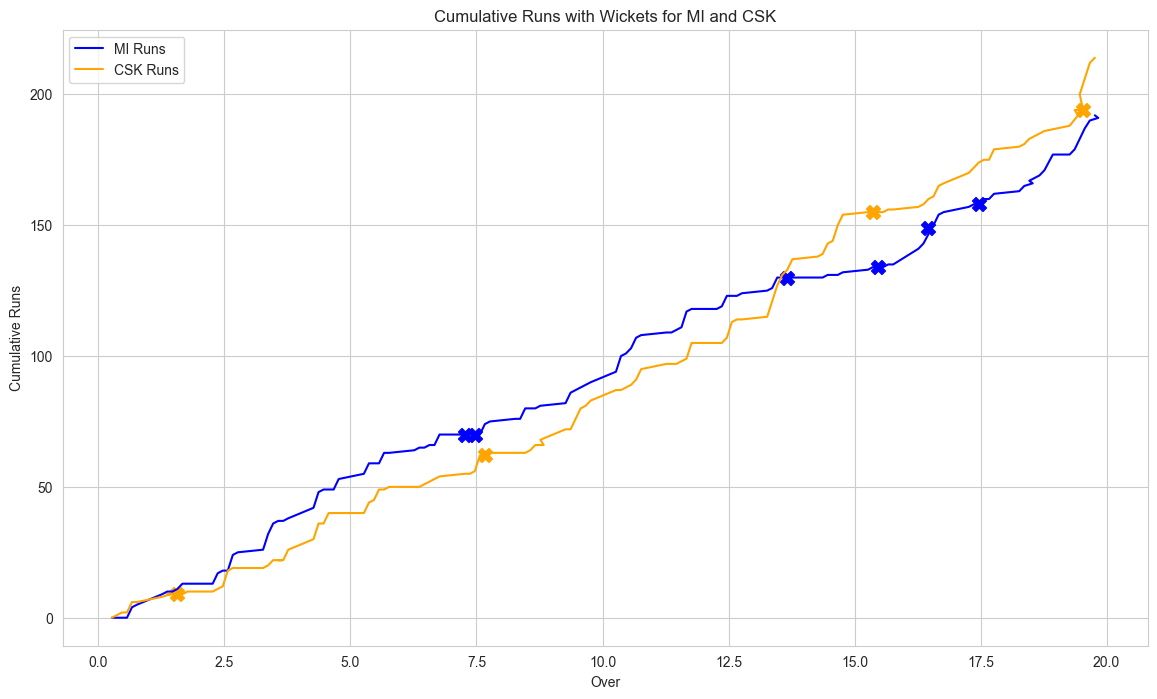

In [20]:
deliveries_df['wickets_taken'] = deliveries_df['wicket_type'].notna().astype(int)

# calculate cumulative runs and wickets for each ball for both teams
deliveries_df['cumulative_runs'] = deliveries_df.groupby('batting_team')['runs_total'].cumsum()
deliveries_df['cumulative_wickets'] = deliveries_df.groupby('batting_team')['wickets_taken'].cumsum()

# separate data for both teams
mi_deliveries = deliveries_df[deliveries_df['batting_team'] == 'MI']
csk_deliveries = deliveries_df[deliveries_df['batting_team'] == 'CSK']

# calculating overs for cumulative analysis
mi_deliveries['over_ball'] = mi_deliveries['over'] + (mi_deliveries.groupby('over').cumcount() + 1) / 6
csk_deliveries['over_ball'] = csk_deliveries['over'] + (csk_deliveries.groupby('over').cumcount() + 1) / 6

# plotting cumulative run rates and wickets
fig, ax = plt.subplots(figsize=(14, 8))

# plot for MI
ax.plot(mi_deliveries['over_ball'], mi_deliveries['cumulative_runs'], color='blue', label='MI Runs')
ax.scatter(mi_deliveries[mi_deliveries['wickets_taken'] == 1]['over_ball'], mi_deliveries[mi_deliveries['wickets_taken'] == 1]['cumulative_runs'], color='blue', marker='X', s=100)

# plot for DC
ax.plot(csk_deliveries['over_ball'], csk_deliveries['cumulative_runs'], color='orange', label='CSK Runs')
ax.scatter(csk_deliveries[csk_deliveries['wickets_taken'] == 1]['over_ball'], csk_deliveries[csk_deliveries['wickets_taken'] == 1]['cumulative_runs'], color='orange', marker='X', s=100)

ax.set_title('Cumulative Runs with Wickets for MI and CSK')
ax.set_xlabel('Over')
ax.set_ylabel('Cumulative Runs')
ax.legend()
plt.show()